<a href="https://colab.research.google.com/github/safari-mohammadreza/MWL_GCN_GAT/blob/main/GCN_MWL_Paper_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initialize

In [ ]:
!pip install torch_geometric torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.0.0+cu118.html

Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html


In [ ]:
import os
import pickle
import scipy.io
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.nn import GCNConv, GATConv, global_mean_pool
from torch_geometric.data import Data, Batch
from torch_geometric.loader import DataLoader

from sklearn.model_selection import KFold
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, roc_auc_score,
                             precision_recall_curve)

In [ ]:
path='/content/gdrive/My Drive/Thesis/connectivities_mat_files/'
save_path='/content/gdrive/My Drive/GCN/save'
save_fig='/content/gdrive/My Drive/GCN/figure'

bands=['delta','theta','alpha','beta','gamma']
channels= ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']
category_labels = ['low', 'high']

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
with open(path+'hi_delta', 'rb') as f:
    hi_delta = pickle.load(f)
print(np.shape(hi_delta)) # (1776, 14, 14)
with open(path+'lo_delta', 'rb') as f:
    lo_delta = pickle.load(f)
print(np.shape(lo_delta))

with open(path+'hi_theta', 'rb') as f:
    hi_theta = pickle.load(f)
print(np.shape(hi_theta))
with open(path+'lo_theta', 'rb') as f:
    lo_theta = pickle.load(f)
print(np.shape(lo_theta))

with open(path+'hi_alpha', 'rb') as f:
    hi_alpha = pickle.load(f)
print(np.shape(hi_alpha))
with open(path+'lo_alpha', 'rb') as f:
    lo_alpha = pickle.load(f)
print(np.shape(lo_alpha))

with open(path+'hi_beta', 'rb') as f:
    hi_beta = pickle.load(f)
print(np.shape(hi_beta))
with open(path+'lo_beta', 'rb') as f:
    lo_beta = pickle.load(f)
print(np.shape(lo_beta))

with open(path+'hi_gamma', 'rb') as f:
    hi_gamma = pickle.load(f)
print(np.shape(hi_gamma))
with open(path+'lo_gamma', 'rb') as f:
    lo_gamma = pickle.load(f)
print(np.shape(lo_gamma))

(1776, 14, 14)
(1776, 14, 14)
(1776, 14, 14)
(1776, 14, 14)
(1776, 14, 14)
(1776, 14, 14)
(1776, 14, 14)
(1776, 14, 14)
(1776, 14, 14)
(1776, 14, 14)


In [ ]:
print(hi_alpha[0].shape)

(14, 14)


In [ ]:
data = [hi_delta, lo_delta, hi_theta, lo_theta, hi_alpha, lo_alpha, hi_beta, lo_beta, hi_gamma, lo_gamma]
print(np.shape(data))

(10, 1776, 14, 14)


In [ ]:
# # Function to plot connectivity matrices for each frequency band and category
# def plot_connectivity_sample(data, bands, channels, category_labels):
#     """
#     Plot a sample connectivity matrix for each frequency band and category.

#     Parameters:
#         data (dict): Dictionary containing connectivity matrices for each band and category.
#                      Expected format: {"band_category": np.array (samples, 14, 14)}
#         bands (list): List of frequency bands (e.g., ['delta', 'theta', 'alpha', 'beta', 'gamma']).
#         labels (list): List of channel labels (e.g., ['AF3', 'F7', ...]).
#         category_labels (list): List of category labels (e.g., ['low', 'high']).
#     """
#     for band in bands:
#         for category in category_labels:
#             key = f"{band}_{category}"
#             if key in data:
#                 # Select the first sample
#                 connectivity_matrix = data[key][0]

#                 # Ensure the diagonal is zero
#                 np.fill_diagonal(connectivity_matrix, 0)

#                 # Plot the connectivity matrix
#                 plt.figure(figsize=(8, 6))
#                 plt.imshow(connectivity_matrix, cmap='viridis', interpolation='nearest')
#                 plt.colorbar(label='Connectivity Strength')


#                 # Set axis labels
#                 plt.xticks(ticks=np.arange(len(channels)), labels=channels, rotation=90)
#                 plt.yticks(ticks=np.arange(len(channels)), labels=channels)

#                 # Add title and axis labels
#                 plt.title(f"{band.capitalize()} Connectivity Matrix ({category.capitalize()})")

#                 # Show the plot
#                 plt.tight_layout()
#                 plt.show()

# # Example usage
# # Simulate data for demonstration purposes
# data = {
#     "delta_low": lo_delta,
#     "delta_high": hi_delta,
#     "theta_low": lo_theta,
#     "theta_high": hi_theta,
#     "alpha_low": lo_alpha,
#     "alpha_high": hi_alpha,
#     "beta_low": lo_beta,
#     "beta_high": hi_beta,
#     "gamma_low": lo_gamma,
#     "gamma_high": hi_gamma,
# }

# # plot_connectivity_sample(data, bands, channels, category_labels)

# Optimization

In [ ]:
!pip install optuna
import optuna

In [ ]:
import warnings
warnings.filterwarnings("ignore")


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import optuna
import os

from torch_geometric.nn import GCNConv, GATConv, global_mean_pool, global_max_pool
from torch_geometric.data import Data, Batch
from torch_geometric.loader import DataLoader

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, precision_recall_curve

#####################################################
# 1. Enhanced Model Definition with Residual & Dual Pooling
#####################################################
class EnhancedGCN_GAT_Model(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, fc1_size, dropout=0.3, heads=4):
        super(EnhancedGCN_GAT_Model, self).__init__()
        # First GCN layer
        self.gcn1 = GCNConv(in_channels, hidden_channels)
        self.bn1 = nn.BatchNorm1d(hidden_channels)
        self.dropout = dropout
        # GAT layer
        self.gat1 = GATConv(hidden_channels, hidden_channels, heads=heads, concat=False)
        self.bn2 = nn.BatchNorm1d(hidden_channels)
        # Second GCN layer
        self.gcn2 = GCNConv(hidden_channels, hidden_channels)
        # Final FC layers after dual pooling (concatenating mean and max pool)
        self.fc1 = nn.Linear(2 * hidden_channels, fc1_size)
        self.fc2 = nn.Linear(fc1_size, out_channels)

    def forward(self, x, edge_index, batch, edge_weight=None):
        # 1) First GCN layer
        x = self.gcn1(x, edge_index, edge_weight=edge_weight)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        # 2) GAT layer
        x = self.gat1(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        # 3) Second GCN layer with Residual Connection
        x2 = self.gcn2(x, edge_index)
        x = x + x2  # Residual addition
        # 4) Dual Pooling: mean and max pooling
        mean_pool = global_mean_pool(x, batch)
        max_pool = global_max_pool(x, batch)
        x = torch.cat([mean_pool, max_pool], dim=1)
        # 5) Final FC layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

#####################################################
# 2. Prepare Graph Data
#####################################################
def prepare_graphs(data, labels, bands):
    graphs = []
    for band in bands:
        band_data = data[band]  # shape: (num_trials, 14, 14)
        for j in range(band_data.shape[0]):
            # Remove self-loops
            adj = band_data[j].copy()
            np.fill_diagonal(adj, 0)
            # Create edge indices
            edge_index = torch.tensor(np.array(np.where(adj > 0)), dtype=torch.long)
            edge_weight = torch.tensor(adj[adj > 0], dtype=torch.float)
            # Node features: entire connectivity row (14D)
            x = torch.tensor(adj, dtype=torch.float32)
            y = torch.tensor([labels[band][j]], dtype=torch.long)
            graph = Data(x=x, edge_index=edge_index, edge_attr=edge_weight, y=y)
            graphs.append(graph)
    return graphs

#####################################################
# 3. Load Your Data
#####################################################
# hi_delta, lo_delta, hi_theta, etc. should be preloaded numpy arrays.
data_dict = {
    "delta": np.concatenate((hi_delta, lo_delta)),
    "theta": np.concatenate((hi_theta, lo_theta)),
    "alpha": np.concatenate((hi_alpha, lo_alpha)),
    "beta": np.concatenate((hi_beta, lo_beta)),
    "gamma": np.concatenate((hi_gamma, lo_gamma)),
}

labels = {}
for band in ['delta', 'theta', 'alpha', 'beta', 'gamma']:
    num_total = data_dict[band].shape[0]
    hi = data_dict[band][:num_total // 2]
    lo = data_dict[band][num_total // 2:]
    labels[band] = np.concatenate((np.ones(hi.shape[0]), np.zeros(lo.shape[0]))).astype(int)
    print(f"Label distribution for {band}:", np.bincount(labels[band]))

bands = ['delta', 'theta', 'alpha', 'beta', 'gamma']
graphs = prepare_graphs(data_dict, labels, bands)

#####################################################
# 4. Define the Objective for Hyperparameter Optimization
#####################################################
def objective(trial):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # Adjusted search space for a smaller dataset:
    hidden_channels = trial.suggest_categorical("hidden_channels", [64, 128, 256])
    dropout = trial.suggest_float("dropout", 0.1, 0.5)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
    n_splits = trial.suggest_int("n_splits", 8, 11)
    fc1_size = trial.suggest_categorical("fc1_size", [32, 64, 128])

    num_epochs = 100
    early_stopping_patience = 10
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_val_acc = []

    for fold, (train_idx, test_idx) in enumerate(kf.split(graphs)):
        train_set = [graphs[i] for i in train_idx]
        test_set = [graphs[i] for i in test_idx]
        train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
        test_loader = DataLoader(test_set, batch_size=32)

        model = EnhancedGCN_GAT_Model(
            in_channels=14,
            hidden_channels=hidden_channels,
            out_channels=2,
            fc1_size=fc1_size,
            dropout=dropout
        ).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        class_weights = torch.tensor([1.0, 1.2]).to(device)
        loss_fn = nn.CrossEntropyLoss(weight=class_weights)

        best_val_acc = 0
        patience_counter = 0
        best_model_state = None

        for epoch in range(num_epochs):
            model.train()
            train_preds, train_trues = [], []
            for batch in train_loader:
                batch = batch.to(device)
                optimizer.zero_grad()
                out = model(batch.x, batch.edge_index, batch.batch, edge_weight=batch.edge_attr)
                loss = loss_fn(out, batch.y)
                loss.backward()
                optimizer.step()
                train_preds.extend(out.argmax(dim=1).cpu().numpy())
                train_trues.extend(batch.y.cpu().numpy())
            train_acc = accuracy_score(train_trues, train_preds)

            model.eval()
            val_preds, val_trues = [], []
            with torch.no_grad():
                for batch in test_loader:
                    batch = batch.to(device)
                    out = model(batch.x, batch.edge_index, batch.batch, edge_weight=batch.edge_attr)
                    val_preds.extend(out.argmax(dim=1).cpu().numpy())
                    val_trues.extend(batch.y.cpu().numpy())
            val_acc = accuracy_score(val_trues, val_preds)

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_model_state = model.state_dict()
                patience_counter = 0
            else:
                patience_counter += 1
            if patience_counter > early_stopping_patience:
                break
        fold_val_acc.append(best_val_acc)
    avg_val_acc = np.mean(fold_val_acc)

    # Log trial info
    print(f"Trial {trial.number}: hidden_channels={hidden_channels}, dropout={dropout:.3f}, "
          f"learning_rate={learning_rate:.5f}, n_splits={n_splits}, fc1_size={fc1_size} -> "
          f"Avg Val Acc: {avg_val_acc:.4f}")

    return avg_val_acc

#####################################################
# 5. Run Hyperparameter Optimization with Optuna
#####################################################
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=15)  # Adjust number of trials as needed

# Print the best trial and its hyperparameters:
print("Best trial:")
best_trial = study.best_trial
print(f"  Value: {best_trial.value}")
print("  Params:")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

#####################################################
# 6. Optionally, Plot the Optimization History
#####################################################
optuna.visualization.plot_optimization_history(study)
plt.show()


Label distribution for delta: [1776 1776]
Label distribution for theta: [1776 1776]
Label distribution for alpha: [1776 1776]
Label distribution for beta: [1776 1776]
Label distribution for gamma: [1776 1776]


[I 2025-03-29 09:18:23,910] A new study created in memory with name: no-name-38d64aa3-9cda-4d14-ad3a-2c0829398fbf
<ipython-input-11-530bd6673222>:111: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be acc

KeyboardInterrupt: 

In [ ]:
#####################################################
# 1. Model Definition
#####################################################
class GCN_GAT_Model(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5, heads=4):
        super(GCN_GAT_Model, self).__init__()
        self.gcn1 = GCNConv(in_channels, hidden_channels)
        self.bn1 = nn.BatchNorm1d(hidden_channels)
        self.dropout = dropout
        self.gat1 = GATConv(hidden_channels, hidden_channels, heads=heads, concat=False)
        self.bn2 = nn.BatchNorm1d(hidden_channels)
        self.gcn2 = GCNConv(hidden_channels, hidden_channels)
        self.fc1 = nn.Linear(hidden_channels, 64)
        self.fc2 = nn.Linear(64, out_channels)

    def forward(self, x, edge_index, batch, edge_weight=None):
        # 1) First GCN layer
        x = self.gcn1(x, edge_index, edge_weight=edge_weight)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        # 2) GAT layer
        x = self.gat1(x, edge_index)  # GATConv doesn't support edge_weight by default
        x = self.bn2(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        # 3) Second GCN layer
        x = self.gcn2(x, edge_index)
        # 4) Pooling
        x = global_mean_pool(x, batch)
        # 5) Final MLP layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

#####################################################
# 2. Prepare Graph Data
#####################################################
def prepare_graphs(data, labels, bands):
    graphs = []
    for band in bands:
        band_data = data[band]  # shape: (num_trials, 14, 14)
        for j in range(band_data.shape[0]):
            # Remove self-loops
            adj = band_data[j].copy()
            np.fill_diagonal(adj, 0)
            # Create edge indices
            edge_index = torch.tensor(np.array(np.where(adj > 0)), dtype=torch.long)
            edge_weight = torch.tensor(adj[adj > 0], dtype=torch.float)
            # Node features: entire connectivity row (14D)
            x = torch.tensor(adj, dtype=torch.float32)
            y = torch.tensor([labels[band][j]], dtype=torch.long)
            graph = Data(x=x, edge_index=edge_index, edge_attr=edge_weight, y=y)
            graphs.append(graph)
    return graphs

#####################################################
# 3. Load Your Data
#####################################################
# Each shape: (1776, 14, 14)
# hi_delta, lo_delta, hi_theta, etc. should be preloaded numpy arrays.
data_dict = {
    "delta": np.concatenate((hi_delta, lo_delta)),
    "theta": np.concatenate((hi_theta, lo_theta)),
    "alpha": np.concatenate((hi_alpha, lo_alpha)),
    "beta": np.concatenate((hi_beta, lo_beta)),
    "gamma": np.concatenate((hi_gamma, lo_gamma)),
}

labels = {}
for band in ['delta', 'theta', 'alpha', 'beta', 'gamma']:
    num_total = data_dict[band].shape[0]
    hi = data_dict[band][:num_total // 2]
    lo = data_dict[band][num_total // 2:]
    labels[band] = np.concatenate((np.ones(hi.shape[0]), np.zeros(lo.shape[0]))).astype(int)
    print(f"Label distribution for {band}:", np.bincount(labels[band]))

bands = ['delta', 'theta', 'alpha', 'beta', 'gamma']
graphs = prepare_graphs(data_dict, labels, bands)

#####################################################
# 4. Define the Objective for Hyperparameter Optimization
#####################################################
def objective(trial):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # Hyperparameters to optimize
    hidden_channels = trial.suggest_categorical("hidden_channels", [128, 256])
    dropout = trial.suggest_float("dropout", 0.1, 0.6)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
    n_splits = trial.suggest_int("n_splits", 8, 11)

    num_epochs = 100
    early_stopping_patience = 10
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_val_acc = []

    for fold, (train_idx, test_idx) in enumerate(kf.split(graphs)):
        train_set = [graphs[i] for i in train_idx]
        test_set = [graphs[i] for i in test_idx]
        train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
        test_loader = DataLoader(test_set, batch_size=32)

        model = GCN_GAT_Model(in_channels=14, hidden_channels=hidden_channels, out_channels=2, dropout=dropout).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=5, factor=0.5, verbose=False)
        class_weights = torch.tensor([1.0, 1.2]).to(device)
        loss_fn = nn.CrossEntropyLoss(weight=class_weights)

        best_val_acc = 0
        patience_counter = 0
        best_model_state = None

        for epoch in range(num_epochs):
            model.train()
            train_preds, train_trues = [], []
            for batch in train_loader:
                batch = batch.to(device)
                optimizer.zero_grad()
                out = model(batch.x, batch.edge_index, batch.batch, edge_weight=batch.edge_attr)
                loss = loss_fn(out, batch.y)
                loss.backward()
                optimizer.step()
                train_preds.extend(out.argmax(dim=1).cpu().numpy())
                train_trues.extend(batch.y.cpu().numpy())
            train_acc = accuracy_score(train_trues, train_preds)

            model.eval()
            val_preds, val_trues = [], []
            with torch.no_grad():
                for batch in test_loader:
                    batch = batch.to(device)
                    out = model(batch.x, batch.edge_index, batch.batch, edge_weight=batch.edge_attr)
                    val_preds.extend(out.argmax(dim=1).cpu().numpy())
                    val_trues.extend(batch.y.cpu().numpy())
            val_acc = accuracy_score(val_trues, val_preds)
            scheduler.step(val_acc)

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_model_state = model.state_dict()
                patience_counter = 0
            else:
                patience_counter += 1
            if patience_counter > early_stopping_patience:
                break
        fold_val_acc.append(best_val_acc)

    avg_val_acc = np.mean(fold_val_acc)
    # Report the average validation accuracy
    return avg_val_acc

#####################################################
# 5. Run Hyperparameter Optimization with Optuna
#####################################################
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=15)  # Adjust number of trials as needed

print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

#####################################################
# 6. Optionally, Plot the Optimization History
#####################################################
optuna.visualization.plot_optimization_history(study)
plt.show()


Label distribution for delta: [1776 1776]
Label distribution for theta: [1776 1776]
Label distribution for alpha: [1776 1776]
Label distribution for beta: [1776 1776]
Label distribution for gamma: [1776 1776]


[I 2025-03-24 16:23:41,103] A new study created in memory with name: no-name-f945b10f-ac2f-4091-b25b-7458798458b5
<ipython-input-10-ab1299b4bb31>:103: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings

Best trial:
  Value: 0.8929054054054053
  Params: 
    hidden_channels: 256
    dropout: 0.2741999281362218
    learning_rate: 0.0007365941237410257
    n_splits: 10


# train

Label distribution for delta: [1776 1776]
Label distribution for theta: [1776 1776]
Label distribution for alpha: [1776 1776]
Label distribution for beta: [1776 1776]
Label distribution for gamma: [1776 1776]

=== Fold 1 ===
Epoch 1, Train Acc: 0.7462, Val Acc: 0.7922
Epoch 2, Train Acc: 0.7734, Val Acc: 0.7937
Epoch 3, Train Acc: 0.7896, Val Acc: 0.7835
Epoch 4, Train Acc: 0.7944, Val Acc: 0.8230
Epoch 5, Train Acc: 0.7995, Val Acc: 0.8142
Epoch 6, Train Acc: 0.8096, Val Acc: 0.7827
Epoch 7, Train Acc: 0.8152, Val Acc: 0.8237
Epoch 8, Train Acc: 0.8152, Val Acc: 0.8325
Epoch 9, Train Acc: 0.8173, Val Acc: 0.7908
Epoch 10, Train Acc: 0.8186, Val Acc: 0.8127
Epoch 11, Train Acc: 0.8274, Val Acc: 0.8098
Epoch 12, Train Acc: 0.8269, Val Acc: 0.8325
Epoch 13, Train Acc: 0.8422, Val Acc: 0.8464
Epoch 14, Train Acc: 0.8471, Val Acc: 0.8383
Epoch 15, Train Acc: 0.8545, Val Acc: 0.8376
Epoch 16, Train Acc: 0.8599, Val Acc: 0.8449
Epoch 17, Train Acc: 0.8580, Val Acc: 0.8530
Epoch 18, Train Acc

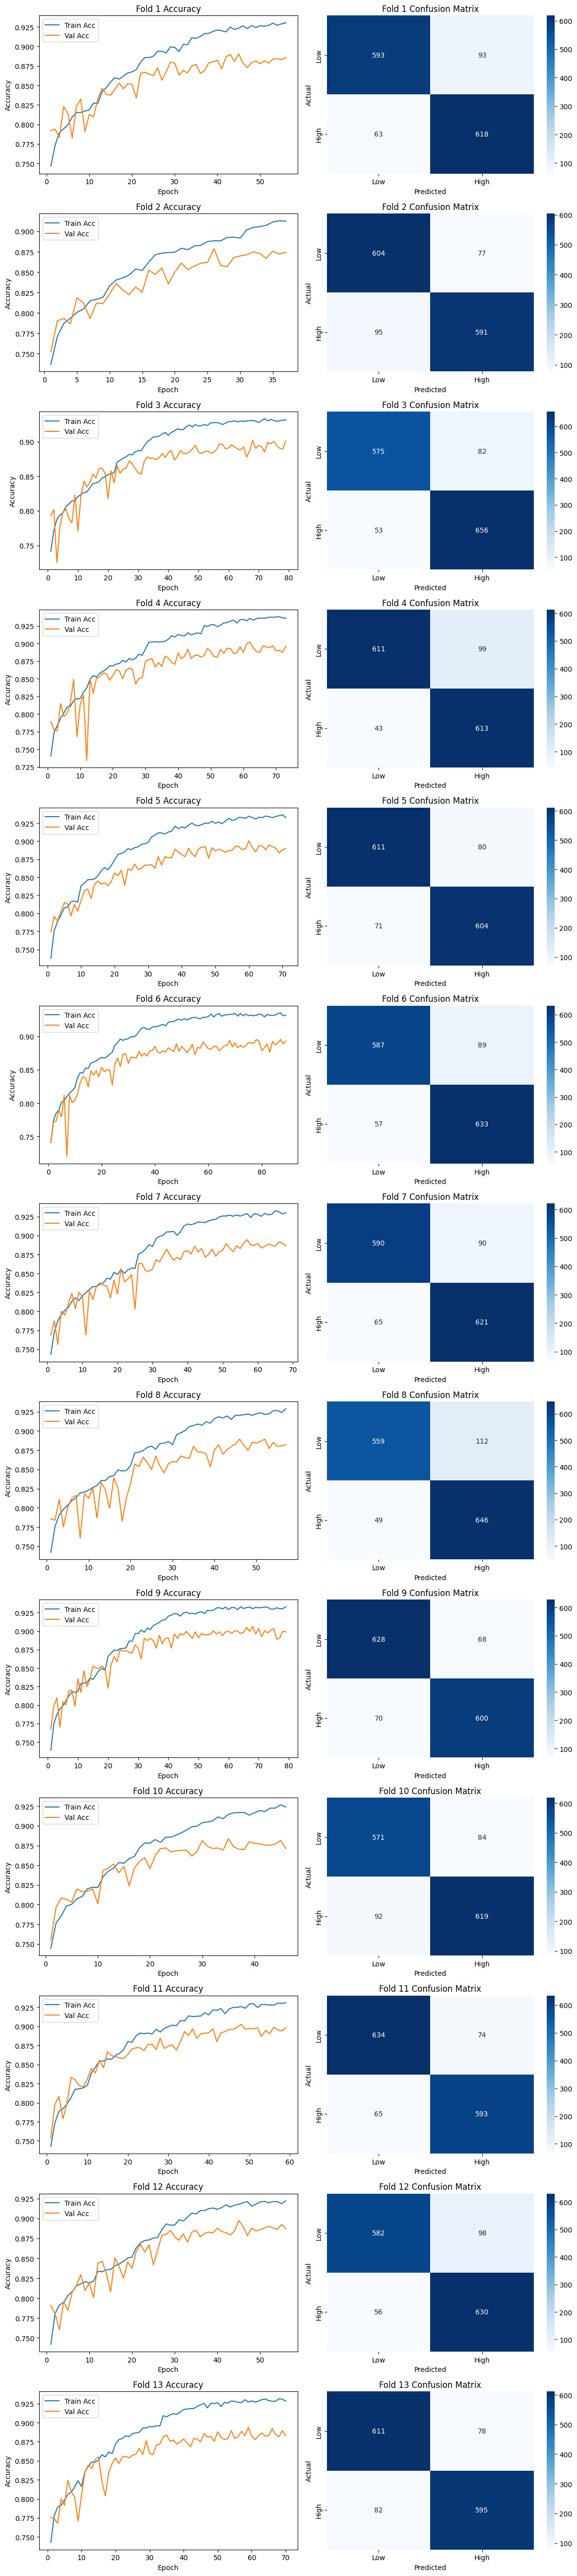


=== Final Metrics Across All Folds ===
Accuracy: 0.8882
Precision: 0.8771
Recall: 0.9030
F1 Score: 0.8899
AUC Score: 0.8882


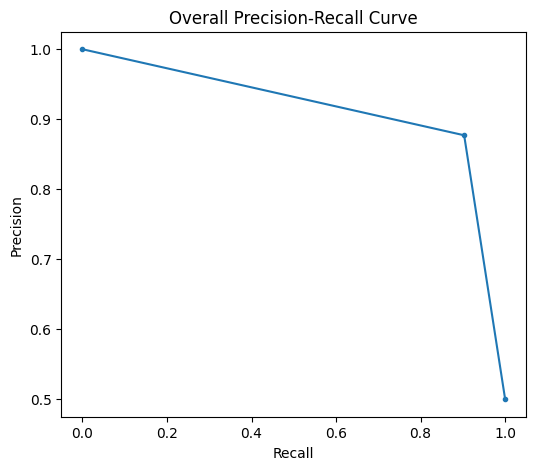

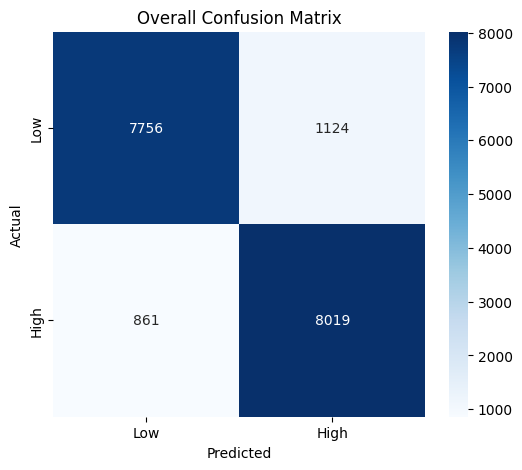

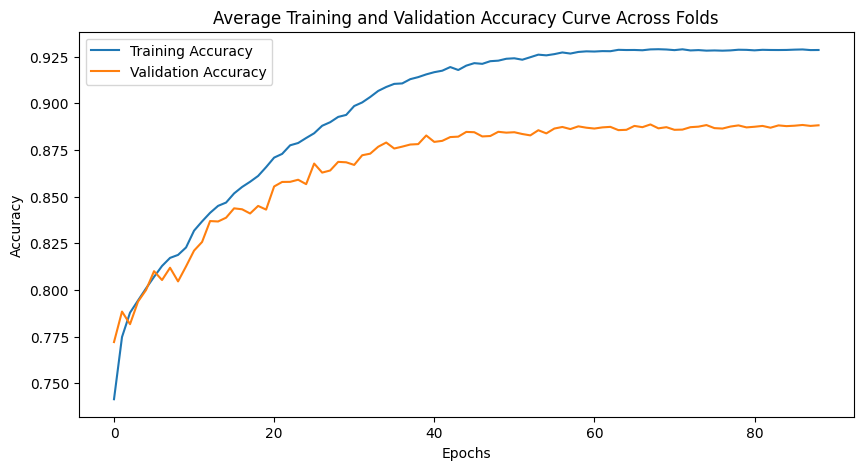

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

from torch_geometric.nn import GCNConv, GATConv, global_mean_pool, global_max_pool
from torch_geometric.data import Data, Batch
from torch_geometric.loader import DataLoader

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, precision_recall_curve

#####################################################
# 1. Enhanced Model Definition with Residual & Dual Pooling
#####################################################
class GCN_GAT_Model(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, fc1_size=128, dropout=0.3, heads=4, fc_dropout=0.3):
        super(GCN_GAT_Model, self).__init__()
        # First GCN layer
        self.gcn1 = GCNConv(in_channels, hidden_channels)
        self.bn1 = nn.BatchNorm1d(hidden_channels)
        self.dropout = dropout
        # GAT layer
        self.gat1 = GATConv(hidden_channels, hidden_channels, heads=heads, concat=False)
        self.bn2 = nn.BatchNorm1d(hidden_channels)
        # Second GCN layer
        self.gcn2 = GCNConv(hidden_channels, hidden_channels)
        # Final FC layers after dual pooling (concatenating mean and max pool)
        self.fc1 = nn.Linear(2 * hidden_channels, fc1_size)
        self.fc1_dropout = nn.Dropout(fc_dropout)  # extra dropout after fc1
        self.fc2 = nn.Linear(fc1_size, out_channels)

    def forward(self, x, edge_index, batch, edge_weight=None):
        # 1) First GCN layer
        x = self.gcn1(x, edge_index, edge_weight=edge_weight)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        # 2) GAT layer
        x = self.gat1(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        # 3) Second GCN layer with Residual Connection
        x2 = self.gcn2(x, edge_index)
        x = x + x2  # Residual addition
        # 4) Dual Pooling: mean and max pooling
        mean_pool = global_mean_pool(x, batch)
        max_pool = global_max_pool(x, batch)
        x = torch.cat([mean_pool, max_pool], dim=1)
        # 5) Final FC layers
        x = F.relu(self.fc1(x))
        x = self.fc1_dropout(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

#####################################################
# 3. Prepare Graph Data
#####################################################
def prepare_graphs(data, labels, bands):
    graphs = []
    for band in bands:
        band_data = data[band]  # shape: (num_trials, 14, 14)
        for j in range(band_data.shape[0]):
            # Remove self-loops
            adj = band_data[j].copy()
            np.fill_diagonal(adj, 0)
            # Create edge indices and edge weights
            edge_index = torch.tensor(np.array(np.where(adj > 0)), dtype=torch.long)
            edge_weight = torch.tensor(adj[adj > 0], dtype=torch.float)
            # Node features: entire connectivity row (14D)
            x = torch.tensor(adj, dtype=torch.float32)
            y = torch.tensor([labels[band][j]], dtype=torch.long)
            graph = Data(x=x, edge_index=edge_index, edge_attr=edge_weight, y=y)
            graphs.append(graph)
    return graphs

#####################################################
# 4. Load Data
#####################################################
# hi_delta, lo_delta, hi_theta, lo_theta, hi_alpha, lo_alpha, hi_beta, lo_beta, hi_gamma, lo_gamma
# should be preloaded numpy arrays of shape (1776, 14, 14) each.
data_dict = {
    "delta": np.concatenate((hi_delta, lo_delta)),
    "theta": np.concatenate((hi_theta, lo_theta)),
    "alpha": np.concatenate((hi_alpha, lo_alpha)),
    "beta": np.concatenate((hi_beta, lo_beta)),
    "gamma": np.concatenate((hi_gamma, lo_gamma)),
}

labels = {}
for band in ['delta', 'theta', 'alpha', 'beta', 'gamma']:
    num_total = data_dict[band].shape[0]
    hi = data_dict[band][:num_total // 2]
    lo = data_dict[band][num_total // 2:]
    labels[band] = np.concatenate((np.ones(hi.shape[0]), np.zeros(lo.shape[0]))).astype(int)
    print(f"Label distribution for {band}:", np.bincount(labels[band]))

bands = ['delta', 'theta', 'alpha', 'beta', 'gamma']
graphs = prepare_graphs(data_dict, labels, bands)

#####################################################
# 5. Cross-Validation and Training
#####################################################
from sklearn.model_selection import KFold

# Use 11-fold cross-validation
kf = KFold(n_splits=13, shuffle=True, random_state=42)
num_epochs = 120  # Increased epochs
early_stopping_patience = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_acc_history_all = []
val_acc_history_all = []
fold_preds_all = []
fold_trues_all = []

# Using tuned hyperparameters
hidden_channels = 512
fc1_size = 128
dropout = 0.3
learning_rate = 0.0007
weight_decay = 1e-4  # added weight decay

for fold, (train_idx, test_idx) in enumerate(kf.split(graphs)):
    print(f"\n=== Fold {fold + 1} ===")
    train_set = [graphs[i] for i in train_idx]
    test_set = [graphs[i] for i in test_idx]
    train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=32)

    model = GCN_GAT_Model(
        in_channels=14,
        hidden_channels=hidden_channels,
        out_channels=2,
        fc1_size=fc1_size,
        dropout=dropout
    ).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    # Use a scheduler to reduce LR when validation plateaus
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.5, verbose=True)

    # For balanced data
    class_weights = torch.tensor([1.0, 1.0]).to(device)
    loss_fn = nn.CrossEntropyLoss(weight=class_weights)

    best_val_acc = 0
    patience = 0
    train_acc_history = []
    val_acc_history = []
    best_model_state = None

    for epoch in range(num_epochs):
        model.train()
        train_preds, train_trues = [], []
        for batch in train_loader:
            batch = batch.to(device)
            # Optionally: toggle augmentation here if desired; currently using original batch.
            batch_used = batch
            optimizer.zero_grad()
            out = model(batch_used.x, batch_used.edge_index, batch_used.batch, edge_weight=batch_used.edge_attr)
            loss = loss_fn(out, batch_used.y)
            loss.backward()
            optimizer.step()

            train_preds.extend(out.argmax(dim=1).cpu().numpy())
            train_trues.extend(batch_used.y.cpu().numpy())
        train_acc = accuracy_score(train_trues, train_preds)

        model.eval()
        val_preds, val_trues = [], []
        with torch.no_grad():
            for batch in test_loader:
                batch = batch.to(device)
                out = model(batch.x, batch.edge_index, batch.batch, edge_weight=batch.edge_attr)
                val_preds.extend(out.argmax(dim=1).cpu().numpy())
                val_trues.extend(batch.y.cpu().numpy())
        val_acc = accuracy_score(val_trues, val_preds)
        scheduler.step(val_acc)

        train_acc_history.append(train_acc)
        val_acc_history.append(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict()
            patience = 0
        else:
            patience += 1
        if patience > early_stopping_patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break

        print(f"Epoch {epoch + 1}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    final_val_preds, final_val_trues = [], []
    model.eval()
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch, edge_weight=batch.edge_attr)
            final_val_preds.extend(out.argmax(dim=1).cpu().numpy())
            final_val_trues.extend(batch.y.cpu().numpy())

    train_acc_history_all.append(train_acc_history)
    val_acc_history_all.append(val_acc_history)
    fold_preds_all.append(final_val_preds)
    fold_trues_all.append(final_val_trues)

#####################################################
# 6. Plot Per-Fold Accuracy Curves and Confusion Matrices
#####################################################
fig, axs = plt.subplots(nrows=len(train_acc_history_all), ncols=2, figsize=(12, 4 * len(train_acc_history_all)))

for i, (train_accs, val_accs) in enumerate(zip(train_acc_history_all, val_acc_history_all)):
    epochs = range(1, len(train_accs) + 1)
    axs[i, 0].plot(epochs, train_accs, label='Train Acc')
    axs[i, 0].plot(epochs, val_accs, label='Val Acc')
    axs[i, 0].set_xlabel('Epoch')
    axs[i, 0].set_ylabel('Accuracy')
    axs[i, 0].set_title(f'Fold {i+1} Accuracy')
    axs[i, 0].legend()
    cm = confusion_matrix(fold_trues_all[i], fold_preds_all[i])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Low', 'High'],
                yticklabels=['Low', 'High'],
                ax=axs[i, 1])
    axs[i, 1].set_title(f'Fold {i+1} Confusion Matrix')
    axs[i, 1].set_xlabel('Predicted')
    axs[i, 1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

#####################################################
# 7. Overall Results Across Folds
#####################################################
all_preds = np.concatenate(fold_preds_all, axis=0)
all_labels = np.concatenate(fold_trues_all, axis=0)

accuracy_final = accuracy_score(all_labels, all_preds)
precision_final = precision_score(all_labels, all_preds)
recall_final = recall_score(all_labels, all_preds)
f1_final = f1_score(all_labels, all_preds)
auc_final = roc_auc_score(all_labels, all_preds)

print(f"\n=== Final Metrics Across All Folds ===")
print(f"Accuracy: {accuracy_final:.4f}")
print(f"Precision: {precision_final:.4f}")
print(f"Recall: {recall_final:.4f}")
print(f"F1 Score: {f1_final:.4f}")
print(f"AUC Score: {auc_final:.4f}")

precisions, recalls, _ = precision_recall_curve(all_labels, all_preds)
plt.figure(figsize=(6, 5))
plt.plot(recalls, precisions, marker='.')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Overall Precision-Recall Curve")
plt.show()

conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Overall Confusion Matrix")
plt.show()

#####################################################
# 8. Plot Average Training/Validation Accuracy
#####################################################
max_epochs = max(len(acc) for acc in train_acc_history_all)
train_acc_padded = np.array([np.pad(acc, (0, max_epochs - len(acc)), 'edge')
                             for acc in train_acc_history_all])
val_acc_padded = np.array([np.pad(acc, (0, max_epochs - len(acc)), 'edge')
                           for acc in val_acc_history_all])
train_acc_mean = np.mean(train_acc_padded, axis=0)
val_acc_mean = np.mean(val_acc_padded, axis=0)

plt.figure(figsize=(10, 5))
plt.plot(train_acc_mean, label='Training Accuracy')
plt.plot(val_acc_mean, label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Average Training and Validation Accuracy Curve Across Folds")
plt.legend()
plt.show()

#####################################################
# 9. Save Final Model (Optional)
#####################################################
# You might choose to retrain on the entire dataset or save the best model from the final fold.
